In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mping
%matplotlib qt

import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip, ImageClip
from IPython.display import HTML
%matplotlib inline

In [2]:
objpoint=np.zeros((9*6,3),np.float32)
objpoint[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
#print("ObjShape",objpoint)

objpoints=[] #3d points in real world
imagepoints=[] #2d ponits in image plane
objpoints1=[] #3d points in real world
imagepoints1=[] #2d ponits in image plane

images=glob.glob('camera_cal/calibration*.jpg')

for fimages in images:
    img=mping.imread(fimages)
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    ret,corners=cv2.findChessboardCorners(gray,(9,6),None)
    
    if(ret==1):
        
        objpoints.append(objpoint)
        imagepoints.append(corners)
        cv2.drawChessboardCorners(img,(9,6),corners,ret)
        
        cv2.imshow('img', img)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()
        


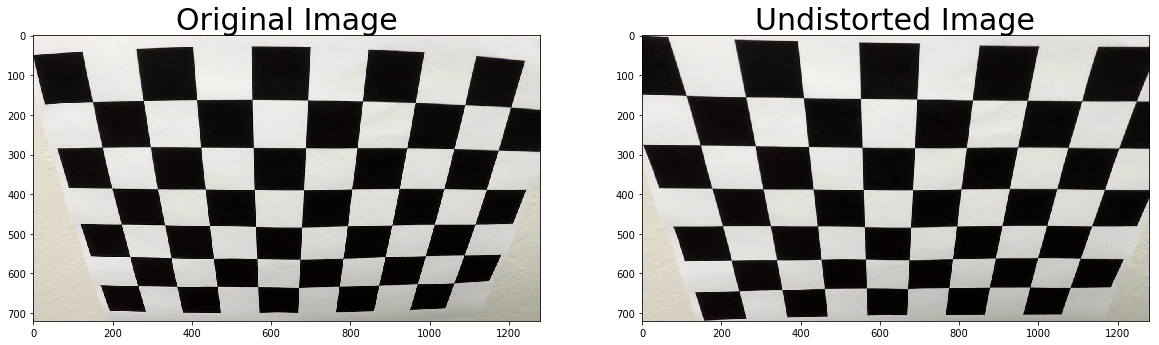

In [3]:
%matplotlib inline
image=mping.imread('camera_cal/calibration2.jpg')
img_size=(image.shape[0],image.shape[1])

ret,mtx,dist,rvec,trvec=cv2.calibrateCamera(objpoints,imagepoints,img_size,None,None)

undistort=cv2.undistort(image,mtx,dist,None,mtx)

cv2.imwrite('output_images/test_undist.jpg',undistort)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=30)


In [4]:
def color_gradient(img,sobel_kernel=9, s_thresh=(100, 255), sx_thresh=(10, 200)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
      
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    r_channel=img[:,:,0]
   
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    # Sobel x and y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,sobel_kernel) # Take the derivative in x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,sobel_kernel) # Take the derivative in y
    abs_sobelx=np.absolute(sobelx)
    scaled_sobel_x = np.uint8(255*abs_sobelx/np.max(abs_sobelx))


    abs_sobel = np.sqrt(sobelx**2+sobely**2) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    thresh=(0.7, 1.5)
    magnitude=np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    abs_magnitude=np.absolute(magnitude)
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])&(abs_magnitude <= thresh[1])&(abs_magnitude >= thresh[0])]=1
    
    # Sobel x_R
    sobel_R = cv2.Sobel(r_channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel) # Take the derivative in x
    abs_sobel_R=np.absolute(sobel_R)
    scaled_sobel_R = np.uint8(255*abs_sobel_R/np.max(abs_sobel_R))
    
    # Threshold x_R gradient
    sxbinary_R = np.zeros_like(scaled_sobel_R)
    sxbinary_R[(scaled_sobel_R >= sx_thresh[0]) & (scaled_sobel_R <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold color channel
    s_binary_R = np.zeros_like(r_channel)
    s_binary_R[(r_channel >= s_thresh[0]) & (r_channel <= s_thresh[1])] = 1
    
    
    color_binary = np.dstack(( np.zeros_like(sxbinary),sxbinary,s_binary_R)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary_R == 1) & (s_binary==1)) | ((sxbinary == 1)|(sxbinary_R==1))] = 1
    return combined_binary,color_binary

In [5]:
def corners_unwarp_lane_lines(img, nx, ny, mtx, dist):
    
        undistorted=cv2.undistort(img,mtx,dist,None,mtx)
        
        #gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
        
        img_size=(undistort.shape[1], undistort.shape[0])
        
        src=np.float32([(570, 470),(690, 475),(150, 720),(1240, 720)])
        
        dst=np.float32([(90, 0),(940, 0), (90, 720), 
                                     (940, 720)
                                     ])

        M_unwrap=cv2.getPerspectiveTransform(src,dst)

        Mvin=cv2.getPerspectiveTransform(dst,src)

        wrapped=cv2.warpPerspective(img,M_unwrap,img_size)
        


        return wrapped, M_unwrap,Mvin,undistorted

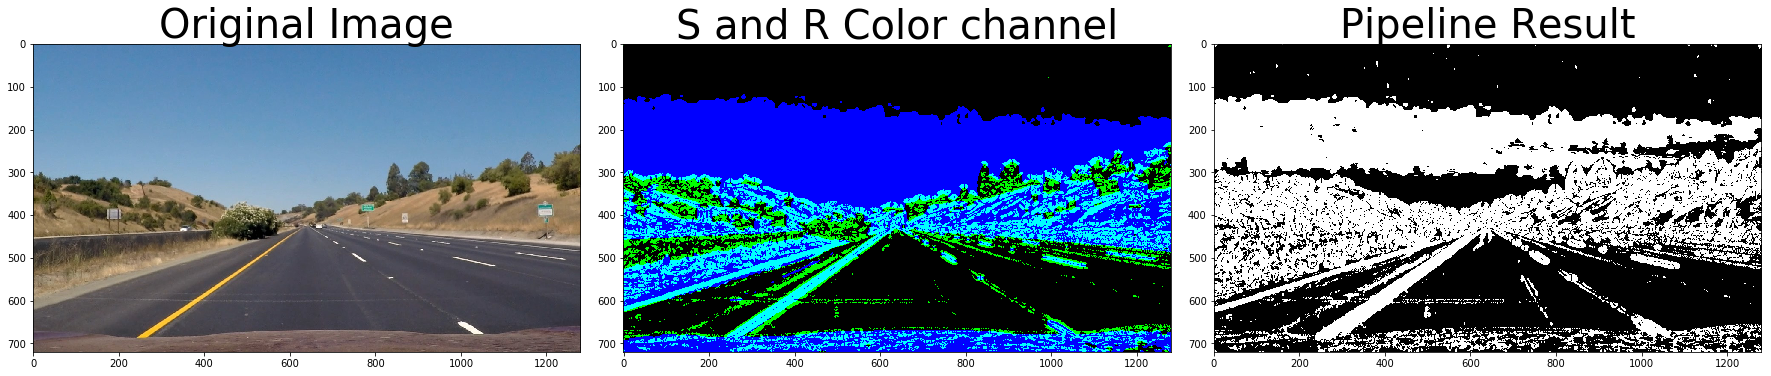

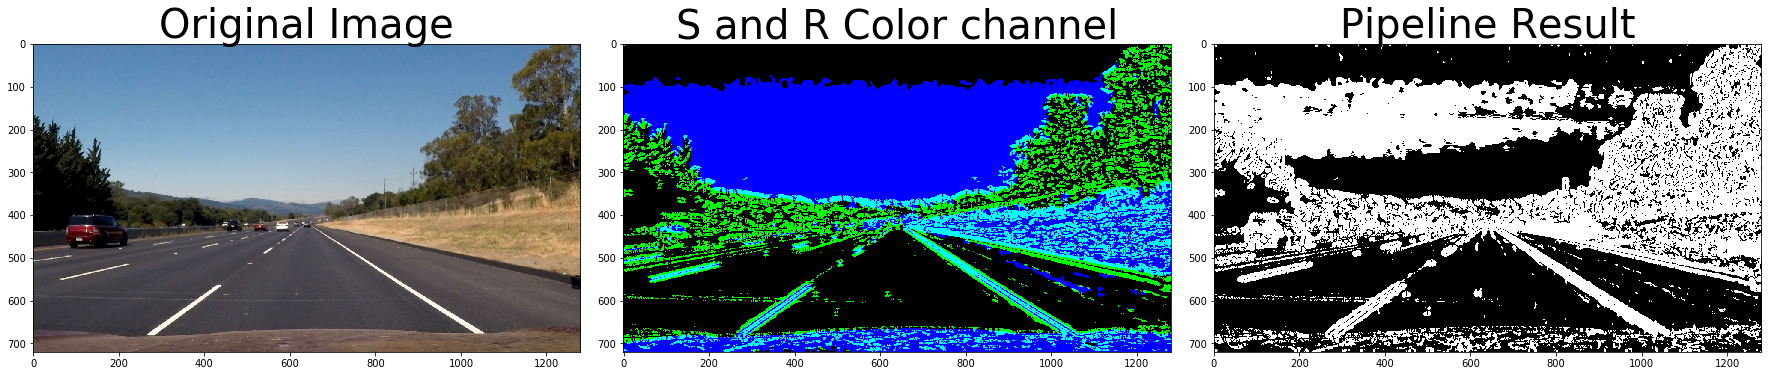

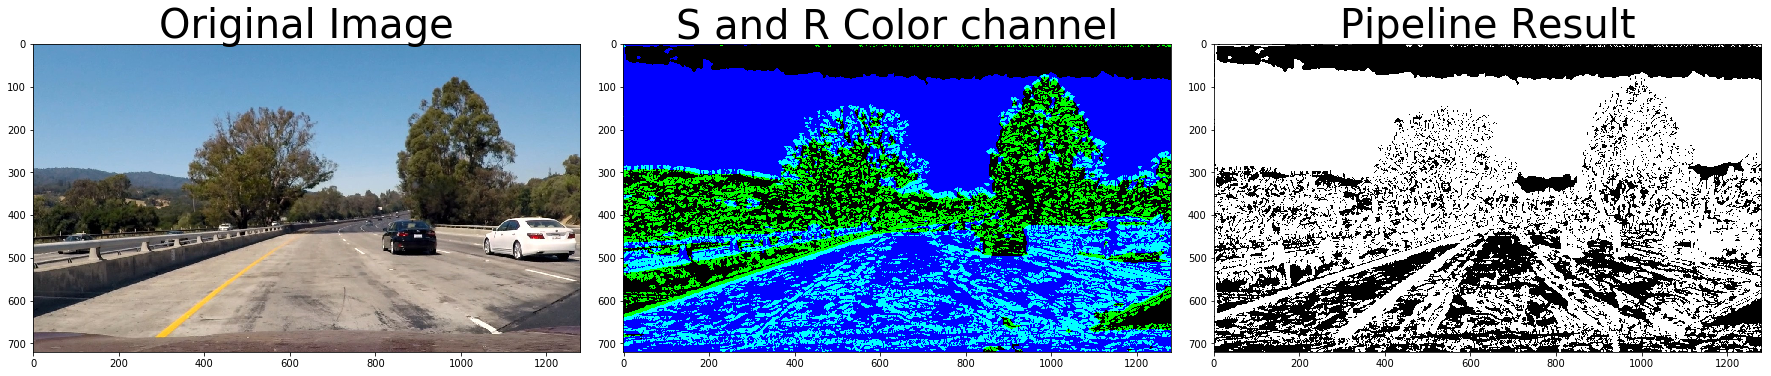

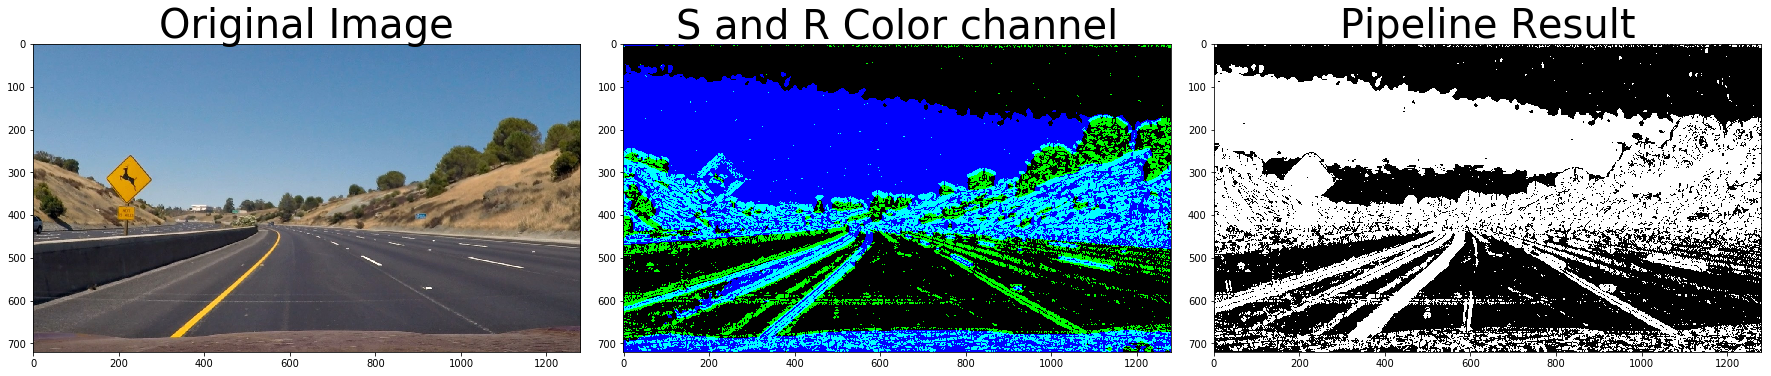

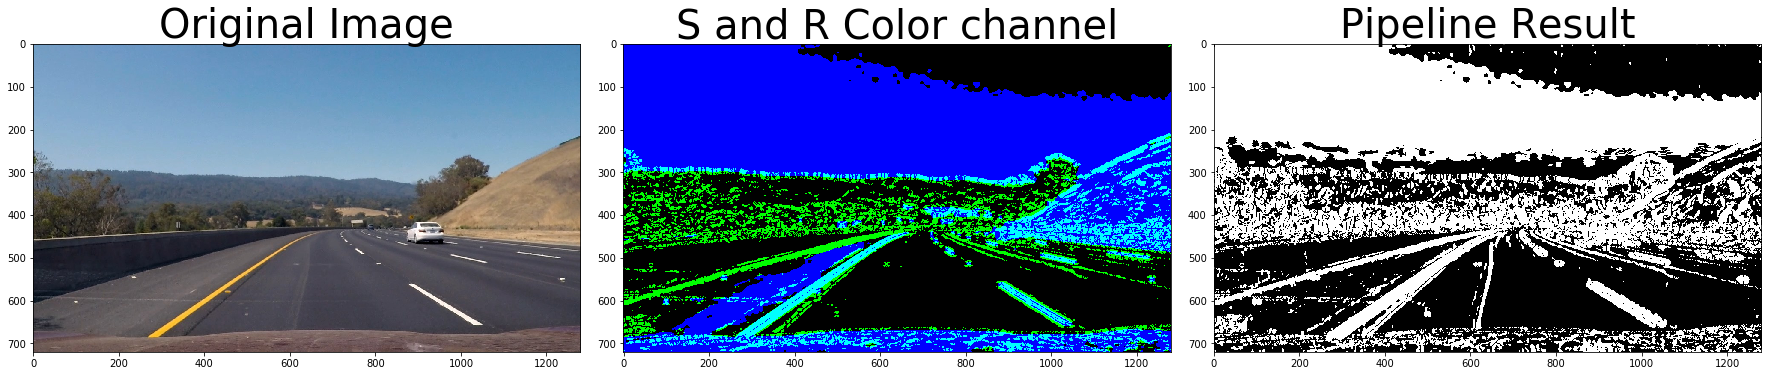

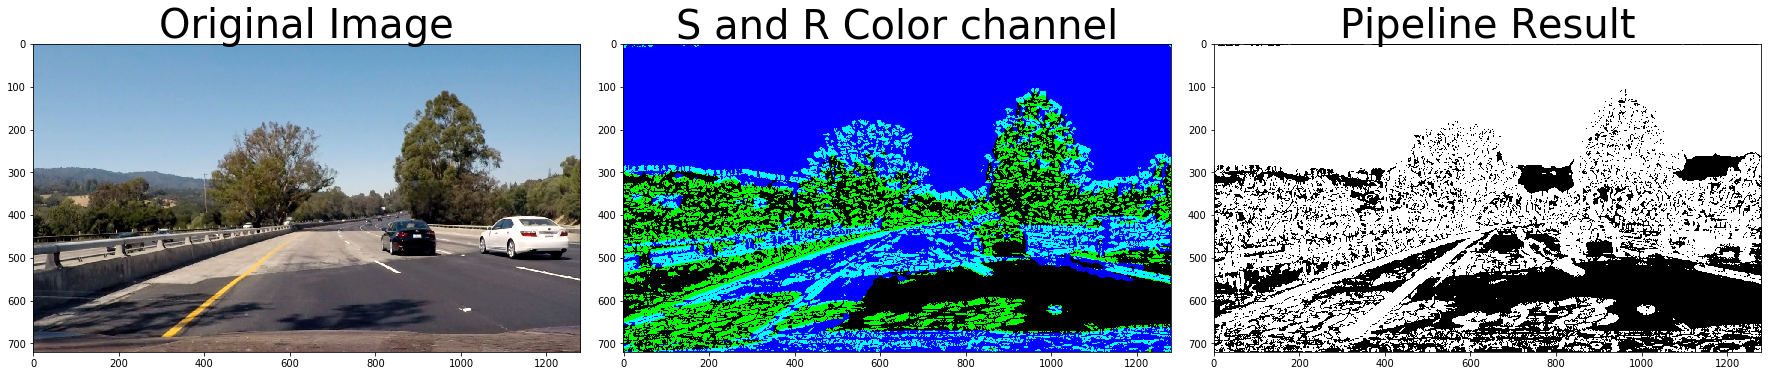

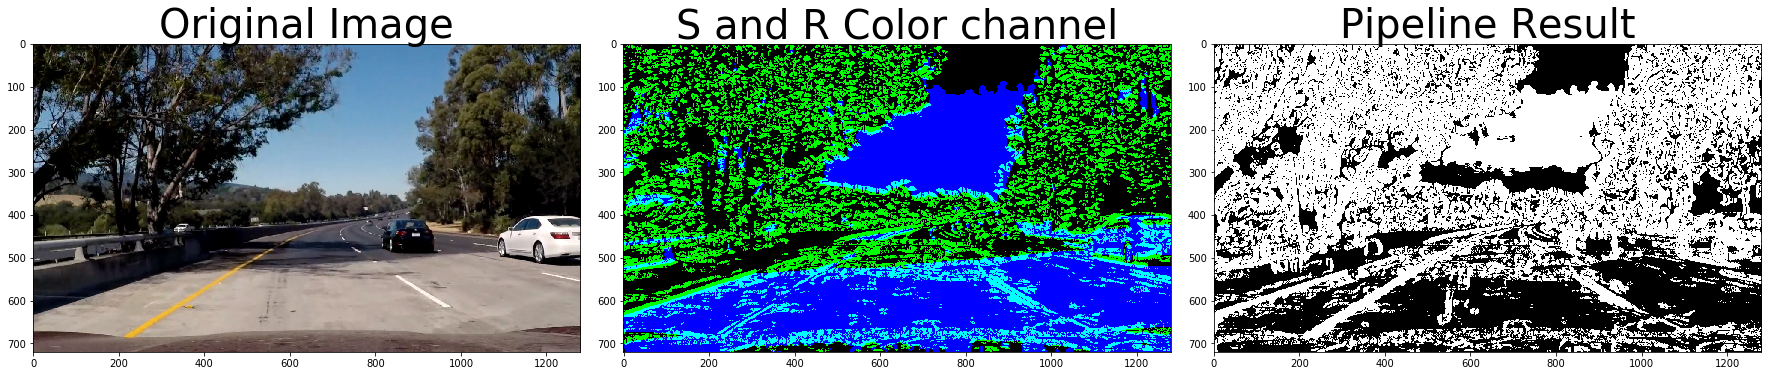

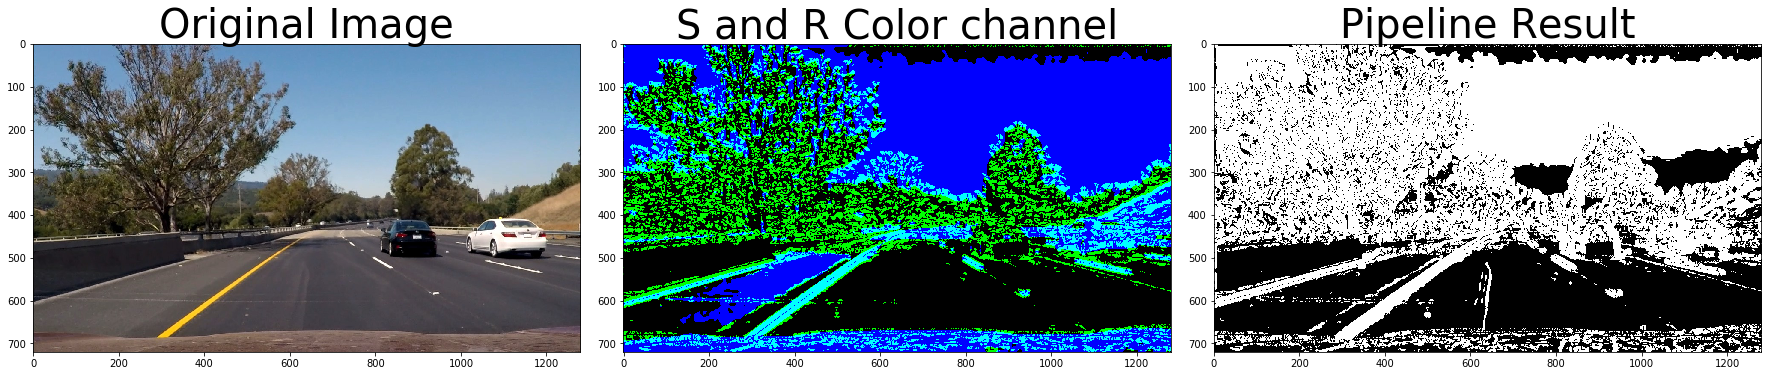

In [6]:
test_images=glob.glob('test_images/*.jpg')
test_out_image=[]
test_img_unwrap=[]
color_binary=[]
top_down_images_unwrap=[]
perspective_M_unwraps=[]
perspective_wrapped_image=[]
Mvin=[]
for fimg in test_images:
    
    img=mping.imread(fimg)
    kernel_size = 17
    blur_img = cv2.GaussianBlur(img,(kernel_size, kernel_size), 0)
    
    
    test_out_image,color_binary=color_gradient(blur_img,sobel_kernel=9)
    
    test_img_unwrap.append(test_out_image)
    top_down_unwrap, perspective_M_unwrap,Mvin,undistorted = corners_unwarp_lane_lines(test_out_image, 9, 6, mtx, dist)

    top_down_images_unwrap.append(top_down_unwrap)
    perspective_wrapped_image.append(undistorted)
    perspective_M_unwraps.append(perspective_M_unwrap)
    
    f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=40)
    
    ax2.imshow(color_binary)
    ax2.set_title('S and R Color channel', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    ax3.imshow(test_out_image,cmap='gray')
    ax3.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
      
    


8


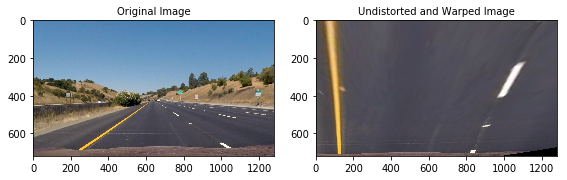

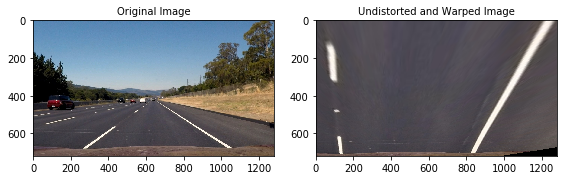

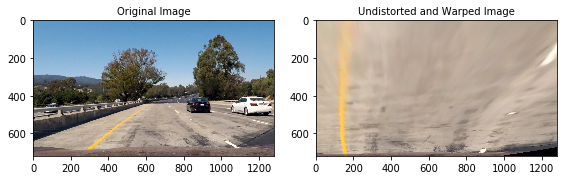

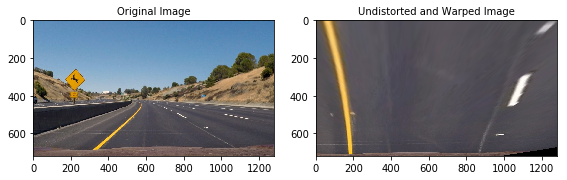

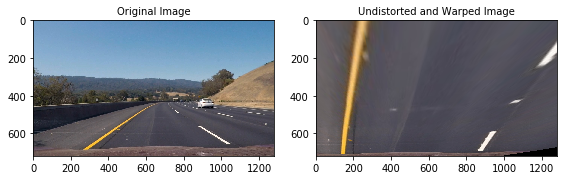

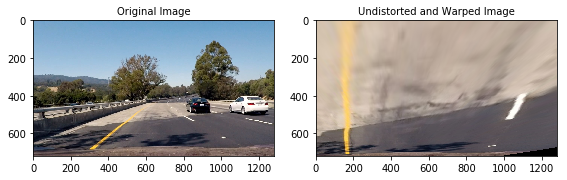

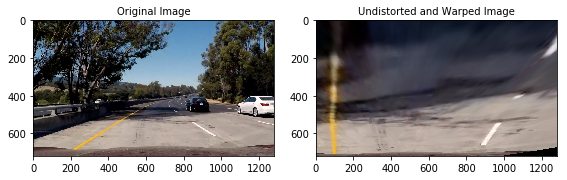

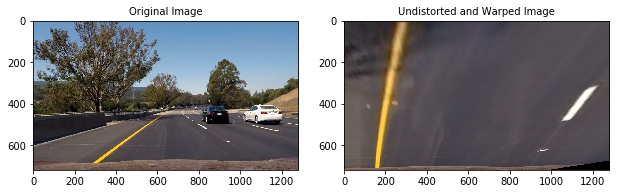

In [7]:
print(len(perspective_wrapped_image))
test_images=glob.glob('test_images/*.jpg')
for fimg in test_images:
    
    img=mping.imread(fimg)
    unwrap, perspective_M_unwrap,Mvin,undistorted = corners_unwarp_lane_lines(img, 9, 6, mtx, dist)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(unwrap)
    ax2.set_title('Undistorted and Warped Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

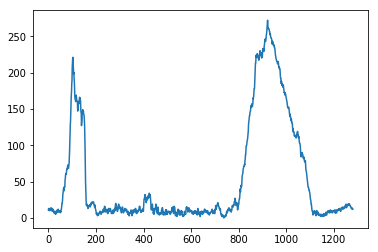

In [8]:
binary_warped=top_down_images_unwrap[1]

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint


nwindows = 9

window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)




In [9]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

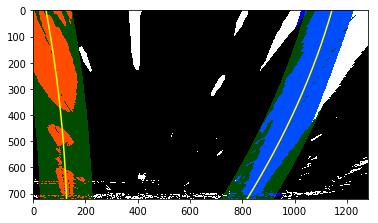

In [10]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

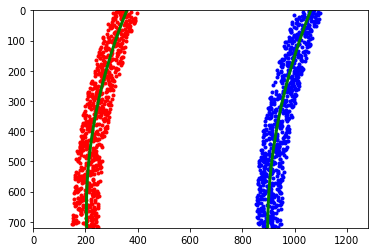

In [11]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [12]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1416.5150291 1592.29391126


In [13]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

464.103598232 m 522.98813176 m


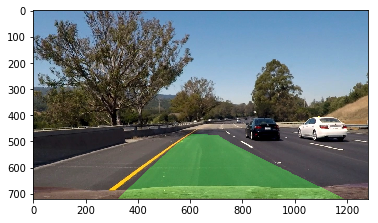

In [14]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Mvin, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(mping.imread(test_images[7]), 1, newwarp, 0.3, 0)
plt.imshow(result)

In [15]:
def find_lanes(binary_warped):
    
    #for binary_warped in top_down_images_unwrap:
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=1)
    #plt.plot(histogram)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)       
    
    return left_lane_inds,right_lane_inds

In [16]:
def pipelines(img):
    
    global left_fit
    global right_fit
    
    test_img_unwrap=[]
    color_binary=[]
    top_down_images_unwrap=[]
    perspective_M_unwraps=[]
    perspective_wrapped_image=[]
    Mvin=[]
    
    img_size=(img.shape[1], img.shape[0])
    
    kernel_size = 15
    blur_img = cv2.GaussianBlur(img,(kernel_size, kernel_size), 0)
    

    test_out_image,color_binary=color_gradient(blur_img,sobel_kernel=9)
    #print(test_out_image)
    test_img_unwrap.append(test_out_image)
    binary_warped, perspective_M_unwrap,Mvin,undistorted = corners_unwarp_lane_lines(test_out_image, 9, 6, mtx, dist)

    perspective_M_unwraps.append(perspective_M_unwrap)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    
    #binary_warped=img
    left_lane_inds,right_lane_inds=find_lanes(binary_warped)
    

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    margin = 100
    
    # Fit a second order polynomial to each
    if(np.all(lefty != None))|(np.all(leftx != None)):
        left_fit = np.polyfit(lefty, leftx, 2)
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    if(np.all(righty != None))|(np.all(rightx != None)):
        right_fit = np.polyfit(righty, rightx, 2)
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  
 

    

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]



    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                          for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                            for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    
    
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # compute the radius of curvature
    average_radius = (left_curverad + right_curverad)/2
    curvature_radius = "Radius of curvature: %.2f m" % average_radius
    
    # compute the offset from the center
    center = (left_fitx[binary_warped.shape[0]-1] + right_fitx[binary_warped.shape[0]-1])/2
    center_offset_pixels = abs(img_size[0]/2 - center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Mvin, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    cv2.putText(result,curvature_radius , (100, 90),  cv2.FONT_HERSHEY_SIMPLEX,1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    
    return result
    

In [17]:
import os
####code for test videos
if os.path.isdir("test_videos_output"):
    pass
else:
    os.mkdir("test_videos_output")
    

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    result = pipelines(image)
    return result
left_fit=[]
right_fit=[]
val=True
white_output = 'project_video_test02.mp4'
clip1 = VideoFileClip("C:\\Users\\user\\Desktop\\project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()

[MoviePy] >>>> Building video project_video_test02.mp4
[MoviePy] Writing video project_video_test02.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:36<00:00,  2.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_test02.mp4 

Wall time: 10min 38s
